# Введение в обработку и классификацию текстов



---


Чуть-чуть на почитать:
[Яндекс Хендбук: нейросети для работы с последовательностями](https://education.yandex.ru/handbook/ml/article/nejroseti-dlya-raboty-s-posledovatelnostyami)



---



**Классификация задач по структуре входов-выходов модели:**
1. Классификация и предсказательные модели:
  **вход** - текст, **выход** - число
2. Информационный поиск:
  **вход** - текст, **выход** - список документов
3. Преобразование и синтез текста:
  **вход** - текст, **выход** - текст

> Одной из основных подзадач является преобразование текста в векторную форму - то есть, получение эмбеддингов модели

**Проблемы и особенности текстового материала:**
1. Многозначность: *“Он был в отличной форме, но на животе она уже не застегивалась.“*
2. Различие между значением и смыслом текста, требующее знание мира: *“Вот это паршивая псина“, “Ну ты молодец“, “Всему я рад и всем доволен“*
3. Сленг: *жиза, краш, кек, каеф* и жаргон: *хакнуть, полундра, модель в евале*
4. Идиомы: *Мир тесен. Вышел из себя. Не май месяц. Ни рыба, ни мясо*
5. Омонимия: *Стали, стекло, косой, ключ*
6. Неологизмы: *Постить, кринж, каршеринг, датасаентист*
7. Нестандартный язык: *“Щас ем мож личку прочитаеш“. “ПФХАЗПАПЗХЫВАЛЫДХАЩЩАА“*
8. Сложные именованные сущности: *“Анна Каренина была первым российским мюзиклом“*
9. Трудность в разметке данных: данных много, часто разметка требуют высокой квалификации, например, при работе с лингвистическими корпусами или перекрестной разметкой на нескольких языках

> Слово само по себе несет смысл. Слов очень много, поэтому на практике приходится работать с разреженным пространством высокой размерности


# Предварительные действия

In [ ]:
!pip install -U datasets huggingface_hub -qq

In [ ]:
!python -m spacy download ru_core_news_sm -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from typing import List, Tuple

In [ ]:
import numpy as np
import pandas as pd

import spacy
from datasets import load_dataset

In [ ]:
from itertools import chain

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
from nltk.util import ngrams
from collections import Counter
from nltk import collocations

## Вспомогательные объекты

In [ ]:
def load_sib200_ru() -> Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], Tuple[List[str], List[int]], List[str]]:
    """
    Загружаем русскоязычную подвыборку из sib200.
    """
    trainset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='train')
    valset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='validation')
    testset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='test')

    X_train, y_train = trainset['text'], trainset['category']
    X_val, y_val = valset['text'], valset['category']
    X_test, y_test = testset['text'], testset['category']

    categories = set(y_train)
    unknown_categories = set(y_val) - categories

    if len(unknown_categories) > 0:
        err_msg = f'The categories {unknown_categories} are represented in the validation set, but they are not represented in the training set.'
        raise RuntimeError(err_msg)

    unknown_categories = set(y_test) - categories
    if len(unknown_categories) > 0:
        err_msg = f'The categories {unknown_categories} are represented in the test set, but they are not represented in the training set.'
        raise RuntimeError(err_msg)

    categories = sorted(list(categories))
    y_train = [categories.index(it) for it in y_train]
    y_val = [categories.index(it) for it in y_val]
    y_test = [categories.index(it) for it in y_test]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), categories

# Задача классификации текста

Задача классификации текста - это задача присвоения текстовым документам классов на основе их содержания/семантики.

Вопрос в том, как представить текст в виде признаков для алгоритма? Самый простой способ - рассматривать слово как начальную единицу, а затем кодировать текст на основании некоторых статистик.

Рассмотрим способы, как закодировать текст таким методом.

## Загрузим данные

In [ ]:
train_data, val_data, test_data, classes_list = load_sib200_ru()

In [ ]:
print(f'Categories: {classes_list}')

Categories: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']


## Предварительная обработка текстовых данных

Для обработки текстовых данных существует несколько библиотек, например:


*   `spacy`
*   `nltk`
*   `pymorphy`
*   `natasha`



In [ ]:
nlp = spacy.load('ru_core_news_sm')

In [ ]:
sample = train_data[0][8]
sample

'Организаторы акции протеста сообщили, что в таких немецких городах, как Берлин, Кельн, Гамбург и Ганновер, собралось около 100 000 человек.'

Лемматизация -- приведения слова к его начальной, словарной форме.

Разница между лемматизацией и стеммингом в том, что под лемматизацией понимается преобразование слова в словарный вид или лемму. Стемминг же чаще всего -- просто отбрасывание изменяемой части слова.

In [ ]:
print([token.lemma_ for token in nlp(sample)])

['организатор', 'акция', 'протест', 'сообщить', ',', 'что', 'в', 'такой', 'немецкий', 'город', ',', 'как', 'берлин', ',', 'кёльн', ',', 'гамбург', 'и', 'ганновер', ',', 'собраться', 'около', '100', '000', 'человек', '.']


Можем убрать знаки препинания и заменить числительные.

In [ ]:
print(
    ['<NUM>' if token.like_num else token.lemma_ for token in nlp(sample) if not token.is_punct]
)

['организатор', 'акция', 'протест', 'сообщить', 'что', 'в', 'такой', 'немецкий', 'город', 'как', 'берлин', 'кёльн', 'гамбург', 'и', 'ганновер', 'собраться', 'около', '<NUM>', '<NUM>', 'человек']


Объединим все

In [ ]:
def normalize_text_by_spacy(s: str, nlp_pipeline: spacy.Language) -> str:
    doc = nlp_pipeline(s)
    lemmas = [('<NUM>' if token.like_num else token.lemma_.lower()) for token in filter(lambda it1: not it1.is_punct, doc)]
    if len(lemmas) == 0:
        return ''
    return ' '.join(lemmas)

In [ ]:
print(normalize_text_by_spacy(sample, nlp))

организатор акция протест сообщить что в такой немецкий город как берлин кёльн гамбург и ганновер собраться около <NUM> <NUM> человек


## Векторизация текстовых данных

$$
\mathbf{x} = (x_1, x_2, \ldots, x_n), \quad \text{где} \,\, x_i = \#\{w_i \in d\}
$$

### Первый подход: Bag Of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(
    token_pattern='\w+|<\w+>',
    ngram_range=(1, 1)  # unigram only
)

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-2788978375.py:4: SyntaxWarning: invalid escape sequence '\w'
  token_pattern='\w+|<\w+>',


In [ ]:
X_sample = bow.fit_transform(
    [normalize_text_by_spacy(it, nlp) for it in train_data[0][:10]]
)

In [ ]:
X_sample

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 192 stored elements and shape (10, 158)>

In [ ]:
X_sample.max()

np.int64(3)

In [ ]:
bow.get_feature_names_out()

array(['<num>', 'а', 'агент', 'акция', 'берлин', 'богатый', 'более',
       'болезнь', 'больший', 'быть', 'в', 'валюта', 'вероятно', 'вода',
       'война', 'вопрос', 'восток', 'впрочем', 'времён', 'вспышка',
       'вызвать', 'выпадать', 'гамбург', 'ганновер', 'где', 'глушь',
       'год', 'горный', 'город', 'государство', 'греческий', 'далее',
       'даниэль', 'данной', 'деревушками', 'довольно', 'доступный',
       'другая', 'жизнь', 'за', 'занятие', 'запад', 'заселить', 'заявить',
       'зима', 'знание', 'и', 'из', 'известный', 'изысканный', 'иметь',
       'их', 'к', 'как', 'катание', 'когда', 'конституция', 'конфликт',
       'корень', 'которая', 'красота', 'кёльн', 'лантань', 'лодкам',
       'лыжа', 'мера', 'миротворец', 'много', 'молдова', 'море', 'морями',
       'мочь', 'на', 'научный', 'начало', 'начать', 'не', 'незаселённый',
       'некоторый', 'немецкий', 'ни', 'них', 'но', 'ночной', 'область',
       'обнаружить', 'оказаться', 'около', 'окружить', 'они', 'оон',
      

### Второй подход: TF-IDF

$$
\mathrm{TF\text{-}IDF}(w_i, d) = \left(\frac{f_{i,d}}{\sum_{k} f_{k,d}}\right) \times \log \frac{N}{1 + n_i}
$$
где
* $f_{i,d}$ — количество вхождений слова $w_i$ в документе $d$
* $N$ — общее число документов в корпусе,
* $n_i$ — количество документов, содержащих слово $w_i$


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(
    token_pattern='\w+|<\w+>',
    ngram_range=(1, 1),  # unigram only
    min_df=2,
    max_df=0.95
)

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3570840725.py:4: SyntaxWarning: invalid escape sequence '\w'
  token_pattern='\w+|<\w+>',


In [ ]:
X_sample = tf_idf.fit_transform(
    [normalize_text_by_spacy(it, nlp) for it in train_data[0][:100]]
)
X_sample

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 920 stored elements and shape (100, 230)>

In [ ]:
X_sample.max()

np.float64(1.0)

In [ ]:
print(tf_idf.get_feature_names_out().tolist())

['<num>', 'а', 'авария', 'авиакомпания', 'автомобиль', 'атом', 'африка', 'безопасность', 'билет', 'более', 'больше', 'больший', 'большинство', 'британия', 'были', 'было', 'быть', 'в', 'век', 'весь', 'включать', 'вода', 'водитель', 'война', 'вокруг', 'вопрос', 'восток', 'вращаться', 'время', 'все', 'всего', 'вы', 'гаити', 'где', 'глава', 'год', 'город', 'государство', 'давать', 'даже', 'джон', 'дикий', 'для', 'до', 'дополнительный', 'других', 'европа', 'его', 'если', 'ещё', 'животное', 'за', 'запад', 'заявить', 'земля', 'зрение', 'и', 'игра', 'из', 'известный', 'изменение', 'или', 'им', 'иметь', 'интернет', 'исландия', 'использовать', 'их', 'к', 'как', 'какой', 'качество', 'когда', 'количество', 'компания', 'конец', 'контрольный', 'которая', 'которого', 'который', 'которых', 'масштаб', 'матч', 'между', 'мера', 'место', 'миля', 'министр', 'мир', 'многие', 'много', 'можно', 'море', 'мочь', 'на', 'назад', 'нам', 'настоящий', 'насчёт', 'научный', 'находиться', 'начало', 'начать', 'не', 'нео

## Собираем итоговый класификатор

### Применим логистическую регрессию

$$
P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n)}}
$$

$$
L(\boldsymbol{\beta}) = - \frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right] + \frac{\lambda}{2} \sum_{j=1}^n \beta_j^2
$$


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


classifier = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(token_pattern='\w+', max_df=0.95)),
    ('cls', LogisticRegression(solver='saga', max_iter=500, random_state=42))
])

<>:9: SyntaxWarning: invalid escape sequence '\w'
<>:9: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-1688359922.py:9: SyntaxWarning: invalid escape sequence '\w'
  ('vectorizer', TfidfVectorizer(token_pattern='\w+', max_df=0.95)),


In [ ]:
cv = GridSearchCV(
    estimator=classifier,
    param_grid={
        'vectorizer__min_df': [2, 3, 5],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'cls__C': [1e-1, 1, 10, 100],
        'cls__penalty': ['l1', 'l2']
    },
    scoring='f1_macro',
    cv=5,
    refit=True,
    n_jobs=4,
    verbose=True
)

In [ ]:
X_train = [normalize_text_by_spacy(it, nlp) for it in train_data[0]]
y_train = train_data[1]
cv.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.95,
                                                        token_pattern='\\w+')),
                                       ('cls',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=4,
             param_grid={'cls__C': [0.1, 1, 10, 100],
                         'cls__penalty': ['l1', 'l2'],
                         'vectorizer__min_df': [2, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_macro', verbose=True)

In [ ]:
print('Best parameters:')
print(cv.best_params_)

Best parameters:
{'cls__C': 100, 'cls__penalty': 'l2', 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1)}


$$
\text{F1-macro} = \frac{1}{K} \sum_{k=1}^K \text{F1}_k = \frac{1}{K} \sum_{k=1}^K \frac{2 \cdot \text{precision}_k \cdot \text{recall}_k}{\text{precision}_k + \text{recall}_k}
$$

In [ ]:
print('Best F1-macro:')
print(cv.best_score_)

Best F1-macro:
0.61468397602635


In [ ]:
print(f'Vocabulary size is {len(cv.best_estimator_.named_steps["vectorizer"].vocabulary_)}.')

Vocabulary size is 1618.


In [ ]:
y_pred = cv.predict([normalize_text_by_spacy(it, nlp) for it in test_data[0]])
print(classification_report(y_true=test_data[1], y_pred=y_pred, target_names=classes_list))

                    precision    recall  f1-score   support

     entertainment       0.89      0.42      0.57        19
         geography       0.62      0.47      0.53        17
            health       0.48      0.50      0.49        22
          politics       0.74      0.77      0.75        30
science/technology       0.62      0.75      0.68        51
            sports       0.82      0.72      0.77        25
            travel       0.58      0.65      0.61        40

          accuracy                           0.65       204
         macro avg       0.68      0.61      0.63       204
      weighted avg       0.66      0.65      0.64       204



### Сравним с решающим деревом

In [ ]:
tree_classifier = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(token_pattern='\w+', max_df=0.95)),
    ('cls', DecisionTreeClassifier(random_state=42, min_samples_leaf=10))
])

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3820750894.py:2: SyntaxWarning: invalid escape sequence '\w'
  ('vectorizer', TfidfVectorizer(token_pattern='\w+', max_df=0.95)),


In [ ]:
tree_cv = GridSearchCV(
    estimator=tree_classifier,
    param_grid={
        'vectorizer__min_df': [2, 3, 5],
        'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'cls__max_depth': [3, 4, 10, 100],
    },
    scoring='f1_macro',
    cv=5,
    refit=True,
    n_jobs=4,
    verbose=True
)

In [ ]:
X_train = [normalize_text_by_spacy(it, nlp) for it in train_data[0]]
y_train = train_data[1]
tree_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.95,
                                                        token_pattern='\\w+')),
                                       ('cls',
                                        DecisionTreeClassifier(min_samples_leaf=10,
                                                               random_state=42))]),
             n_jobs=4,
             param_grid={'cls__max_depth': [3, 4, 10, 100],
                         'vectorizer__min_df': [2, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_macro', verbose=True)

In [ ]:
print('Best F1-macro:')
print(tree_cv.best_score_)

Best F1-macro:
0.25714148247645185


In [ ]:
X_test = [normalize_text_by_spacy(it, nlp) for it in test_data[0]]
y_pred = tree_cv.predict(X_test)
print(classification_report(y_true=test_data[1], y_pred=y_pred, target_names=classes_list))

                    precision    recall  f1-score   support

     entertainment       0.18      0.16      0.17        19
         geography       0.33      0.12      0.17        17
            health       0.00      0.00      0.00        22
          politics       0.37      0.37      0.37        30
science/technology       0.34      0.41      0.37        51
            sports       0.32      0.36      0.34        25
            travel       0.42      0.45      0.43        40

          accuracy                           0.31       204
         macro avg       0.28      0.27      0.26       204
      weighted avg       0.30      0.31      0.30       204



### Попробуем catboost
Напоминание: идея бустинга заключается в том, что каждый следующий решающий алгоритм должен улучшать суммарную оценку предыдущих.

In [ ]:
!pip install catboost -q

In [ ]:
from catboost import Pool
from catboost import CatBoostClassifier

In [ ]:
def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.0001,
        eval_metric='TotalF1:average=Macro',
        # task_type='GPU',
        early_stopping_rounds=250,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=25,
    )

In [ ]:
X_train_df = pd.DataFrame(list(train_data[0]), columns=['text'])
y_train_df = pd.Series(train_data[1], name='label')

X_val_df = pd.DataFrame(list(val_data[0]), columns=['text'])
y_val_df = pd.Series(val_data[1], name='label')

X_test_df = pd.DataFrame(list(test_data[0]), columns=['text'])
y_test_df = pd.Series(test_data[1], name='label')

CatBoost уже имеет встроенные алгоритмы предварительной обработки текстовых данных. См. возможные параметры здесь: https://catboost.ai/docs/en/references/training-parameters/#text-processing-parameters

In [ ]:
text_processing = {
    "tokenizers" : [{
        "tokenizer_id" : "Space",
        "separator_type" : "ByDelimiter",
        "delimiter" : " "
    }],

    "dictionaries" : [{
        "dictionary_id" : "BiGram",
        "max_dictionary_size" : "250",
        "occurrence_lower_bound" : "3",
        "gram_order" : "2"
    }, {
        "dictionary_id" : "Word",
        "max_dictionary_size" : "250",
        "occurrence_lower_bound" : "3",
        "gram_order" : "1"
    }],

    "feature_processing" : {
        "default" : [{
            "dictionaries_names" : ["BiGram", "Word"],
            "feature_calcers" : ["BM25"],
            "tokenizers_names" : ["Space"]
        }],
    }
}

In [ ]:
X_train_df['text_pp'] = X_train_df['text'].map(lambda x: normalize_text_by_spacy(x, nlp))

In [ ]:
X_train_df.head()

,text,text_pp
0,Турция с трёх сторон окружена морями: на запад...,турция с <NUM> сторона окружить морями на запа...
1,В начале войны они в основном передвигались по...,в начало война они в основный передвигаться по...
2,По мере того как знание греческого языка ухудш...,по мера того как знание греческий язык ухудшат...
3,"Впрочем, зимой это другая красота и шарм, с го...",впрочем зима это другая красота и шарм с горны...
4,В этих отелях останавливались богатые и извест...,в этот отель останавливаться богатый и известн...


In [ ]:
X_val_df['text_pp'] = X_val_df['text'].map(lambda x: normalize_text_by_spacy(x, nlp))
X_test_df['text_pp'] = X_test_df['text'].map(lambda x: normalize_text_by_spacy(x, nlp))

**Преобразуем в формат Pool**

In [ ]:
train_processed_pool = Pool(
    X_train_df[['text_pp']], y_train_df,
    text_features=['text_pp'],
)

validation_processed_pool = Pool(
    X_val_df[['text_pp']], y_val_df,
    text_features=['text_pp'],
)

test_processed_pool = Pool(
    X_test_df[['text_pp']], y_test_df,
    text_features=['text_pp'],
)

In [ ]:
cb = fit_model(
    train_processed_pool,
    validation_processed_pool,
    text_processing=text_processing
)

0:	learn: 0.3172596	test: 0.1810745	best: 0.1810745 (0)	total: 52.9ms	remaining: 52.9s
25:	learn: 0.2923192	test: 0.2072072	best: 0.2545348 (2)	total: 1.05s	remaining: 39.3s
50:	learn: 0.2951364	test: 0.2268398	best: 0.2545348 (2)	total: 1.9s	remaining: 35.4s
75:	learn: 0.2937041	test: 0.2268398	best: 0.2545348 (2)	total: 2.99s	remaining: 36.4s
100:	learn: 0.2970506	test: 0.2072072	best: 0.2545348 (2)	total: 4.02s	remaining: 35.8s
125:	learn: 0.2988978	test: 0.2268398	best: 0.2545348 (2)	total: 4.88s	remaining: 33.9s
150:	learn: 0.2981095	test: 0.2268398	best: 0.2545348 (2)	total: 5.79s	remaining: 32.6s
175:	learn: 0.3004846	test: 0.2268398	best: 0.2545348 (2)	total: 6.91s	remaining: 32.3s
200:	learn: 0.2998790	test: 0.2268398	best: 0.2545348 (2)	total: 8.03s	remaining: 31.9s
225:	learn: 0.2998790	test: 0.2268398	best: 0.2545348 (2)	total: 9.53s	remaining: 32.6s
250:	learn: 0.3004501	test: 0.2268398	best: 0.2545348 (2)	total: 10.3s	remaining: 30.8s
Stopped by overfitting detector  (250

In [ ]:
X_test = [normalize_text_by_spacy(it, nlp) for it in test_data[0]]
y_pred = tree_cv.predict(X_test)
print(classification_report(y_true=test_data[1], y_pred=y_pred, target_names=classes_list))

                    precision    recall  f1-score   support

     entertainment       0.00      0.00      0.00        19
         geography       0.00      0.00      0.00        17
            health       0.00      0.00      0.00        22
          politics       1.00      0.10      0.18        30
science/technology       0.27      0.96      0.43        51
            sports       0.44      0.32      0.37        25
            travel       1.00      0.10      0.18        40

          accuracy                           0.31       204
         macro avg       0.39      0.21      0.17       204
      weighted avg       0.47      0.31      0.21       204



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Задача очистки и кластеризации документов

In [ ]:
ru_tg_ds = load_dataset("ScoutieAutoML/russian-news-telegram-dataset", split="train[:10%]")
ru_tg_ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

scoutieRussianNewsTelegramDataset.json:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/97151 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'task_id', 'title', 'text', 'url', 'source_link', 'subsource_link', 'views', 'likes', 'create_time', 'crawl_time', 'vector', 'cluster_id', 'ners', 'emo', 'language', 'spam', 'statistics', 'doc_length', 'source', 'subsource', 'marked_up'],
    num_rows: 9715
})

In [ ]:
to_remove = [col for col in ru_tg_ds.column_names if col not in ["id", "text"]]
print(to_remove)
ru_tg_ds = ru_tg_ds.remove_columns(to_remove)

['task_id', 'title', 'url', 'source_link', 'subsource_link', 'views', 'likes', 'create_time', 'crawl_time', 'vector', 'cluster_id', 'ners', 'emo', 'language', 'spam', 'statistics', 'doc_length', 'source', 'subsource', 'marked_up']


In [ ]:
pd.Series(ru_tg_ds['text'][:10])

,0
0,Постоянно отвлекаетесь? Не можете сконцентриро...
1,В Санкт-Петербурге раскрыли банду «чёрных риел...
2,"❗️\nЛукашенко заявил, что Россия не собирается..."
3,❗️\nРайффайзенбанк опроверг тестирование прода...
4,Что посмотреть в тихорецком кинотеатре на выхо...
5,Сегодня на прогулке увидела вроде простой и в ...
6,Москвич забросал детский сад под своими окнами...
7,🏗️\nНа Каширском шоссе на месте завода полимет...
8,🤡\nНастроение в рабочую субботу\nПрислали\nчер...
9,Москвичка купила хлеб во «ВкусВилле». Внутри о...


In [ ]:
def extract_channel(url: str) -> str:
    if url.startswith('http://'):
        url = url[7:]
    elif url.startswith('https://'):
        url = url[8:]
    segments = []
    for seg in url.split('/'):
        if seg:
            segments.append(seg)
            if len(segments) == 2:
                break
    return {'channel': '/'.join(segments)}

In [ ]:
ru_tg_ds = ru_tg_ds.map(lambda x: extract_channel(x['id']), batched=False)

Map:   0%|          | 0/9715 [00:00<?, ? examples/s]

In [ ]:
ru_tg_ds['channel']

Column(['t.me/bazabazon', 't.me/bazabazon', 't.me/bbbreaking', 't.me/bbbreaking', 't.me/gazetatihvesti'])

<Axes: >

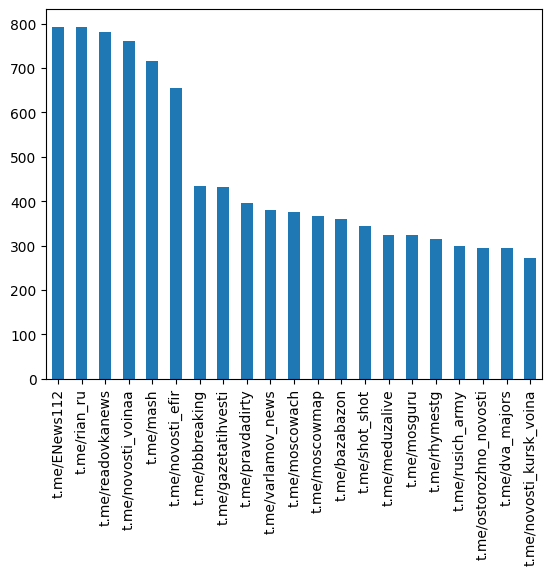

In [ ]:
pd.Series(list(ru_tg_ds['channel'])).value_counts().plot(kind='bar')

## Задание
1. Разбить тексты на предложения.
2. Нормализовать текст.
3. Убрать предложения с наиболее часто встречающимеся паттернами.
4. Кластеризовать текст.

*Используем библиотеку* `Natasha` *для сегментация текста.*  
Сегментация текста - разбиение текста на "смысловые" сегменты. В нашем случае предложения.

Также можно использовать библиотеку `Razdel`

In [ ]:
!pip install natasha -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 91.5 MB/s eta 0:00:00


In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsMorphTagger,
    Doc
)

In [ ]:
segmenter = Segmenter()

In [ ]:
sample = Doc(ru_tg_ds['text'][42])

In [ ]:
sample.segment(segmenter)

In [ ]:
[ds.text for ds in sample.sents]

['В Москве впервые появились велосипедные парковки для курьеров.',
 'По новым правилам на некоторых улицах столицы велосипеды больше нельзя бросать на тротуарах и обочине — и их надо парковать в специальных местах.',
 'По словам представителей Департамента транспорта Москвы, парковки появились в первую очередь из-за активного развития курьерского сервиса в городе.',
 'Всего по столице за день выполняется порядка 500 тысяч заказов — и значительное количество из них курьеры доставляют именно на двух колёсах.',
 'В итоге, чтобы не создавать заторы на тротуарах, власти и решили создать парковки на Большой Бронной улице, в Смоленском переулке, на Лесной улице, Шереметьевской улице и во Втором Монетчиковском переулке.']

In [ ]:
def segment_and_normalize(segmenter: Segmenter, spicy_nlp, x: str):
    """
    Разбиваем на предложения и приводим к lowercase.
    """
    doc = Doc(x)
    doc.segment(segmenter)
    sentences = [
        [dt.text.lower() for dt in ds.tokens] for ds in doc.sents
    ]

    return {'list_of_sents': sentences}

In [ ]:
ru_tg_ds = ru_tg_ds.map(
    lambda x: segment_and_normalize(segmenter=segmenter, spicy_nlp=nlp, x=x['text']), batched=False
)

Map:   0%|          | 0/9715 [00:00<?, ? examples/s]

## Подсчет n-gram

In [ ]:
ngrams_counter = Counter()
N = 4

for list_of_sents in ru_tg_ds['list_of_sents']:
    for list_of_tokens in list_of_sents:
        ngrams_counter.update(Counter(ngrams(list_of_tokens, n=N)))

In [ ]:
pd.Series(ngrams_counter.values()).describe([0, 0.5, .75, .90, .95, .99])

,0
count,543747.000000
mean,1.112907
std,2.410042
min,1.000000
0%,1.000000
50%,1.000000
75%,1.000000
90%,1.000000
95%,2.000000
99%,3.000000


In [ ]:
ngrams_counter.most_common(50)

[(('📢', 'прямой', 'эфир', '-'), 650),
 (('прямой', 'эфир', '-', 'подписаться'), 650),
 (('❗️', 'подписывайся', 'на', 'mash'), 549),
 (('подписывайтесь', ',', 'это', 'baza'), 335),
 (('❗', 'подписывайтесь', ',', 'это'), 334),
 (('"', 'тихорецкие', 'вести', '"'), 329),
 (('тихорецкие', 'вести', '"', '-'), 326),
 (('_', '_', '_', '_'), 326),
 (('🎯', 'подписывайся', 'на', 'shot'), 323),
 (('подписывайся', 'на', 'shot', '📩'), 323),
 (('на', 'shot', '📩', 'прислать'), 323),
 (('shot', '📩', 'прислать', 'новость'), 323),
 (('подписаться', '/', 'предложить', 'новость'), 268),
 (('/', 'предложить', 'новость', '🎣'), 268),
 (('предложить', 'новость', '🎣', '🐟'), 268),
 (('новость', '🎣', '🐟', '🐡'), 268),
 (('🎣', '🐟', '🐡', '🐠'), 268),
 (('🐟', '🐡', '🐠', '📰'), 268),
 (('🐡', '🐠', '📰', '🗞'), 268),
 ((',', 'в', 'том', 'числе'), 197),
 (('о', 'том', ',', 'что'), 181),
 (('https', ':', '/', '/'), 177),
 (('по', 'его', 'словам', ','), 119),
 (('по', 'данным', 'shot', ','), 114),
 (('❗', 'подписывайся', 'на', 

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} = \frac{log{p(x|y)}}{p(x)} = \frac{p(y|x)}{p(y)}$$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

In [ ]:
# bigram_measures = collocations.BigramAssocMeasures()

# bigram_finder = collocations.BigramCollocationFinder.from_documents()
# bigrams = bigram_finder.nbest(bigram_measures.pmi, 40)
# bigrams

## Очистка текстов

In [ ]:
top50_ngrams = ngrams_counter.most_common(50)
top50_ngrams = [trg[0] for trg in top50_ngrams]
top50_ngrams

[('📢', 'прямой', 'эфир', '-'),
 ('прямой', 'эфир', '-', 'подписаться'),
 ('❗️', 'подписывайся', 'на', 'mash'),
 ('подписывайтесь', ',', 'это', 'baza'),
 ('❗', 'подписывайтесь', ',', 'это'),
 ('"', 'тихорецкие', 'вести', '"'),
 ('тихорецкие', 'вести', '"', '-'),
 ('_', '_', '_', '_'),
 ('🎯', 'подписывайся', 'на', 'shot'),
 ('подписывайся', 'на', 'shot', '📩'),
 ('на', 'shot', '📩', 'прислать'),
 ('shot', '📩', 'прислать', 'новость'),
 ('подписаться', '/', 'предложить', 'новость'),
 ('/', 'предложить', 'новость', '🎣'),
 ('предложить', 'новость', '🎣', '🐟'),
 ('новость', '🎣', '🐟', '🐡'),
 ('🎣', '🐟', '🐡', '🐠'),
 ('🐟', '🐡', '🐠', '📰'),
 ('🐡', '🐠', '📰', '🗞'),
 (',', 'в', 'том', 'числе'),
 ('о', 'том', ',', 'что'),
 ('https', ':', '/', '/'),
 ('по', 'его', 'словам', ','),
 ('по', 'данным', 'shot', ','),
 ('❗', 'подписывайся', 'на', 'mash'),
 ('после', 'того', ',', 'как'),
 ('t', '.', 'me', '/'),
 ('вести', '"', '-', 'будьте'),
 ('"', '-', 'будьте', 'в'),
 ('-', 'будьте', 'в', 'курсе'),
 ('будьте', 

In [ ]:
('-', 'людям', 'о', 'людях') in top50_ngrams

True

In [ ]:
ru_tg_ds['list_of_sents'][0]
for sent in ru_tg_ds['list_of_sents'][0]:
    print(sent)

['постоянно', 'отвлекаетесь', '?']
['не', 'можете', 'сконцентрироваться', '?']
['сами', 'диагностировали', 'себе', 'сдвг', '?']
['тогда', 'это', 'видео', 'для', 'вас', '.']
['разработчики', 'из', 'memenome', 'представили', 'сервис', ',', 'который', 'генерирует', 'видео', 'на', 'основе', 'текста', ',', 'который', 'нужно', 'запомнить', '.']
['нейросеть', 'выделяет', 'из', 'текста', 'главное', 'и', 'пересказывает', 'всё', 'так', ',', 'чтобы', 'было', 'понятно', 'подросткам', '.']
['текст', 'читает', 'сгенерированный', 'голос', 'на', 'фоне', 'паркур-карт', 'в', 'minecraft', 'или', 'геймплея', 'subway', 'surfer', '.']
['к', 'чёрту', 'скучный', 'текст', ',', 'лучше', 'посмотрите', 'видео', '.']
['❗', 'подписывайтесь', ',', 'это', 'baza']


In [ ]:
def clean_text(
        list_of_sents: List[List[str]],
        stop_ngrams: List[Tuple[str, str, str]],
        N=4
) -> List[List[str]]:
    """
    Удаляем в тексте предложения, которые содержат частые n-граммы.
    """
    new_list_of_sents = []
    for sent in list_of_sents:
        add_it = True
        for ngram in ngrams(sent, N):
            assert isinstance(ngram, tuple)
            assert len(ngram) == N
            if ngram in stop_ngrams:  # здесь можно также отсекать и по стоп словам (https, erid, и т.д.)
                add_it = False
                break
        if add_it:
            new_list_of_sents.append(sent)

    return {'clean_list_of_sents': new_list_of_sents}

In [ ]:
ru_tg_ds = ru_tg_ds.map(lambda x: clean_text(x['list_of_sents'], stop_ngrams=top50_ngrams), batched=False)

Map:   0%|          | 0/9715 [00:00<?, ? examples/s]

In [ ]:
ru_tg_ds = ru_tg_ds.map(
    lambda x: {'text_processed': ' '.join(list(chain.from_iterable(x['list_of_sents'])))},
    batched=False
)

Map:   0%|          | 0/9715 [00:00<?, ? examples/s]

In [ ]:
ru_tg_ds.column_names

['id',
 'text',
 'channel',
 'list_of_sents',
 'clean_list_of_sents',
 'text_processed']

## Векторизация

In [ ]:
ru_tg_df = ru_tg_ds.select_columns(['channel', 'text_processed']).to_pandas()
ru_tg_df

,channel,text_processed
0,t.me/bazabazon,постоянно отвлекаетесь ? не можете сконцентрир...
1,t.me/bazabazon,в санкт-петербурге раскрыли банду « чёрных рие...
2,t.me/bbbreaking,"❗️ лукашенко заявил , что россия не собирается..."
3,t.me/bbbreaking,❗️ райффайзенбанк опроверг тестирование продаж...
4,t.me/gazetatihvesti,что посмотреть в тихорецком кинотеатре на выхо...
...,...,...
9710,t.me/varlamov_news,в ночь на 1 октября израильская армия начала н...
9711,t.me/varlamov_news,жителям центральной части израиля в ближайшее ...
9712,t.me/varlamov_news,сообщается о стрельбе с пострадавшими в районе...
9713,t.me/ENews112,"так выглядит частный дом , на который упали об..."


In [ ]:
import re

In [ ]:
re.findall(r"(?u)\b[^\W\d_]{2,}\b", "Привет мир ! 123 4 a ab abc123")

['Привет', 'мир', 'ab']

In [ ]:
stop_words = ['не', 'на', 'по', 'из', 'за', 'до', 'для', 'что', 'как', 'но', 'бы', 'он', 'она', 'мы', 'то',
              'это', 'от', 'также', 'ни', 'где', 'же', 'уже', 'со', 'во', 'они', 'их']

In [ ]:
tf_idf = TfidfVectorizer(
    token_pattern=r"(?u)\b[^\W\d_]{2,}\b",  # по умолчанию r"(?u)\b\w\w+\b" => выделяем unicode строки длиной 2 и более
    ngram_range=(1, 1),  # unigram only
    max_features=2000,
    stop_words=stop_words
    # min_df=2,
    # max_df=0.95
)

In [ ]:
X_ru_tg = tf_idf.fit_transform(ru_tg_df['text_processed'])
X_ru_tg

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 204914 stored elements and shape (9715, 2000)>

In [ ]:
tf_idf.get_feature_names_out()

array(['apple', 'baza', 'discord', ..., 'якобы', 'января', 'яндекс'],
      dtype=object)

## Разбиение на кластеры

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(
    n_clusters=5,
    n_init=20,
    random_state=42
)

In [ ]:
ru_tg_clusters = kmeans.fit_predict(X_ru_tg)

In [ ]:
Counter(ru_tg_clusters)

Counter({np.int32(0): 4848,
         np.int32(1): 2614,
         np.int32(3): 283,
         np.int32(4): 1685,
         np.int32(2): 285})

In [ ]:
ru_tg_df['cluster'] = ru_tg_clusters

In [ ]:
top_words = tf_idf.get_feature_names_out()

In [ ]:
ru_tg_df['text_processed_add'] = ru_tg_df['text_processed'].str.findall(r"(?u)\b[^\W\d_]{2,}\b")
ru_tg_df['text_processed_add'] = ru_tg_df['text_processed_add'].map(
    lambda x: [t for t in x if t in top_words]
)
ru_tg_df['text_processed_add'] = ru_tg_df['text_processed_add'].map(lambda x: ' '.join(x).strip())
ru_tg_df

,channel,text_processed,cluster,text_processed_add
0,t.me/bazabazon,постоянно отвлекаетесь ? не можете сконцентрир...,0,постоянно можете сами диагностировали себе тог...
1,t.me/bazabazon,в санкт-петербурге раскрыли банду « чёрных рие...,1,санкт петербурге которые себя квартиры людей д...
2,t.me/bbbreaking,"❗️ лукашенко заявил , что россия не собирается...",0,заявил россия собирается через страны ес добав...
3,t.me/bbbreaking,❗️ райффайзенбанк опроверг тестирование продаж...,0,продажи информация долларов появилась сайте te...
4,t.me/gazetatihvesti,что посмотреть в тихорецком кинотеатре на выхо...,0,посмотреть тихорецком есть несколько октября н...
...,...,...,...,...
9710,t.me/varlamov_news,в ночь на 1 октября израильская армия начала н...,0,ночь октября армия начала операцию этого своем...
9711,t.me/varlamov_news,жителям центральной части израиля в ближайшее ...,0,жителям центральной части израиля ближайшее вр...
9712,t.me/varlamov_news,сообщается о стрельбе с пострадавшими в районе...,1,сообщается районе юге место медики the times п...
9713,t.me/ENews112,"так выглядит частный дом , на который упали об...",1,так выглядит дом который бпла жители пострадал...


## Визуализируем наши кластеры

In [ ]:
%pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

0 cluster


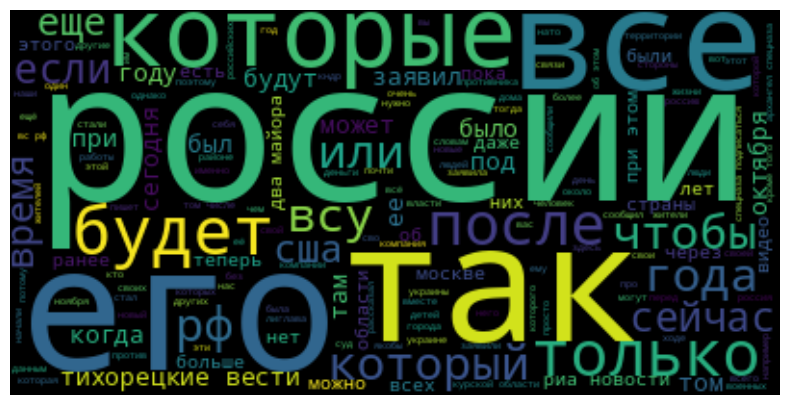

1 cluster


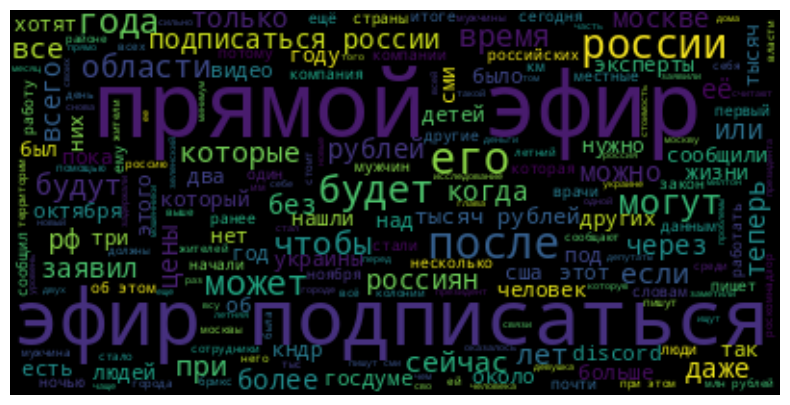

2 cluster


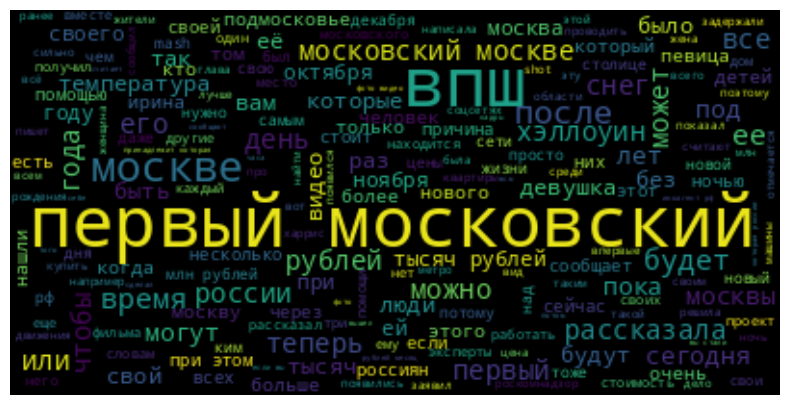

3 cluster


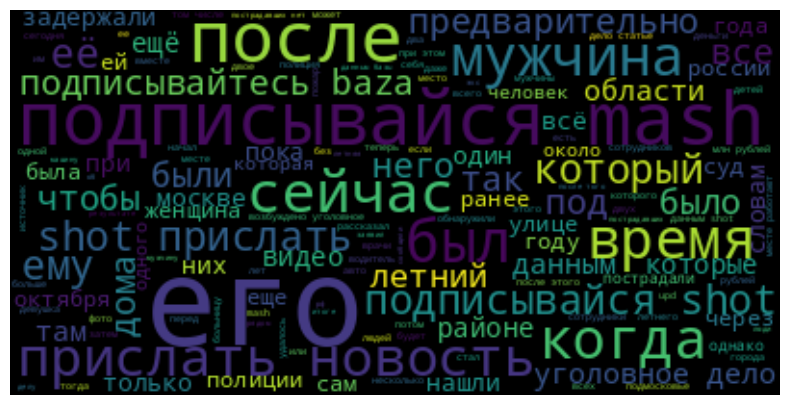

In [ ]:
for i in range(ru_tg_clusters.max()):
    print(i, 'cluster')
    all_texts = ru_tg_df[ru_tg_df['cluster'] == i]
    all_texts = ' '.join(all_texts['text_processed_add'].to_list())

    wordcloud = WordCloud().generate(all_texts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Extra:

## Словарь, закон Ципфа и закон Хипса


---



*Закон Ципфа* -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.



Визуализация на текстах википедии:

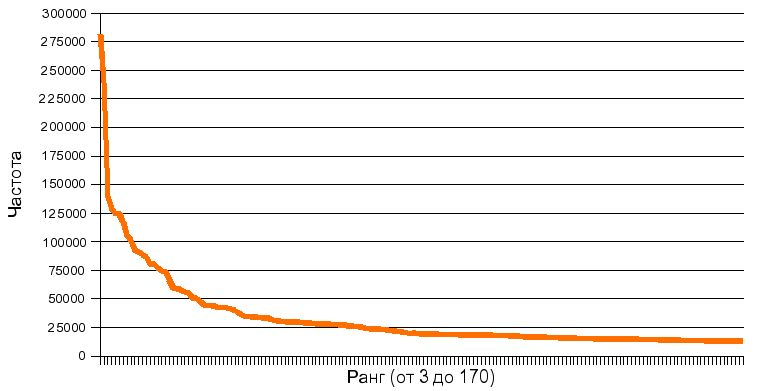

### Пробуем повторить

In [ ]:
corpus = list(chain.from_iterable(list(ru_tg_ds['list_of_sents'])))
corpus = list(chain.from_iterable(corpus))
print(len(corpus))

744626


In [ ]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[(',', 42938),
 ('.', 40425),
 ('в', 26941),
 ('и', 16445),
 ('на', 15070),
 ('—', 7513),
 ('с', 7179),
 ('«', 6625),
 ('»', 6612),
 ('не', 6172)]

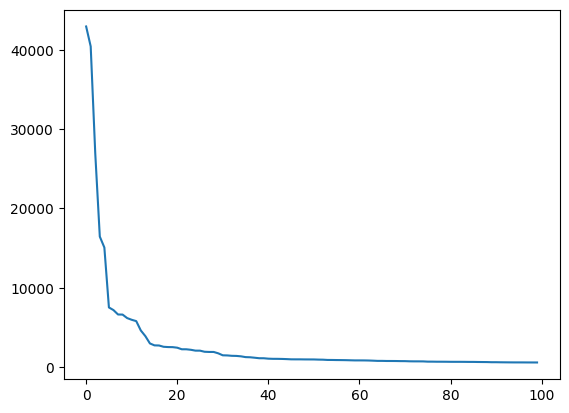

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

*Закон Хипса* -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.